In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os.path import join
import time

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# scDRS tools
import scdrs.util as util
import scdrs.data_loader as dl
import scdrs.method as md

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# Constants 
DATA_PATH='/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data'
OUT_PATH=DATA_PATH+'/results/fig_simu.rv1'

# Trait info 
DF_GS = pd.read_csv(DATA_PATH+'/gs_file/magma_10kb_top1000_zscore.74_traits.rv1.gs', sep='\t', index_col=0)
DF_TRAIT_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.tsv', sep='\t')
DF_TRAIT_INFO.index = DF_TRAIT_INFO['Trait_Identifier']
DF_TRAIT_SS_INFO = pd.read_csv(DATA_PATH+'/supp_table.rv1/trait_info.UKB_subsample.tsv', sep='\t', index_col=0)

DF_TRAIT_145K_INFO = pd.read_excel('/n/holystore01/LABS/price_lab/Lab/ldsc/sumstats_formatted/Description.xlsx',
                                   sheet_name=1)
DF_TRAIT_145K_INFO.index = DF_TRAIT_145K_INFO['Trait_Identifier']
temp_df = pd.read_excel('/n/holystore01/LABS/price_lab/Lab/ldsc/sumstats_formatted/Description.xlsx',
                        sheet_name=0)
temp_df.index = temp_df['Trait_Identifier']
DF_TRAIT_145K_INFO = DF_TRAIT_145K_INFO.join(temp_df[['N']])

# Set score file 
DIC_SCORE_PATH = {
    'full' : DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore',
    'ukb145k' : DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore_UKB145K_26trait',
    'ss' : DATA_PATH+'/score_file/score.tms_facs_with_cov.magma_10kb_top1000_zscore_UKB_subsample',
}

# Subsample parameters 
UKB_TRAIT_LIST = [
    x.split('.subsample_300K')[0] for x in os.listdir(DIC_SCORE_PATH['ss']) if 'subsample_300K' in x]
SUBSAMPLE_LIST = [10, 30, 100, 300]

# Set trait list
DIC_TRAIT_LIST = {}
DIC_TRAIT_LIST['full'] = UKB_TRAIT_LIST.copy()
DIC_TRAIT_LIST['ukb145k'] = [
    x.replace('.score.gz','') for x in os.listdir(DIC_SCORE_PATH['ukb145k']) if x.endswith('score.gz')]
DIC_TRAIT_LIST['ss'] = [
    x.replace('.score.gz','') for x in os.listdir(DIC_SCORE_PATH['ss']) if x.endswith('score.gz')]
for score in DIC_TRAIT_LIST:
    print('{:^20s} {:^20s}'.format(score, 'n_trait=%d'%len(DIC_TRAIT_LIST[score])))
    
# MAGMA
DIC_MAGMA = {}
DIC_MAGMA['full'] = pd.read_csv(
    '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/MAGMA-v108/'
    'MAGMA_v108_GENE_10_ZSTAT_for_scDRS.txt', sep='\t')
DIC_MAGMA['ukb145k'] = DIC_MAGMA['full'][DIC_TRAIT_LIST['ukb145k']].copy()
DIC_MAGMA['ss'] = pd.read_csv(
    '/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data/gene_annotation/MAGMA-v108/'
    'MAGMA_v108_GENE_10_ZSTAT_for_scDRS_subsampled_refmt.txt', sep='\t', index_col=0)

        full              n_trait=35     
      ukb145k             n_trait=26     
         ss              n_trait=140     


In [3]:
# Load score 
dic_score = {x:pd.DataFrame() for x in DIC_SCORE_PATH}
for score in DIC_SCORE_PATH:
    for trait in DIC_TRAIT_LIST[score]:
        file_path = DIC_SCORE_PATH[score]+'/%s.score.gz'%trait
        if os.path.exists(file_path):
            temp_df = pd.read_csv(file_path, sep='\t', index_col=0)
            temp_df.columns = ['%s.%s'%(trait,x) for x in temp_df.columns]
            temp_df['%s.fdr'%trait] = multipletests(temp_df['%s.pval'%trait], method='fdr_bh')[1]
            dic_score[score] = pd.concat([dic_score[score], temp_df], axis=1)
        else:
            print('# missing: %s'%file_path)   

### Analysis

In [4]:
# Power
df_stats = pd.DataFrame(columns=[
    'res', 'trait', 'n_sample', 'h2g', 'h2g_z', 'log10_me', 
    'n_sig', 'prop_zg3', 'score_q001', 'score_q005', 'score_q01', 'corr_full',
], dtype=float)

# Full data UKB460K 
for trait in UKB_TRAIT_LIST:
    df_stats.loc[trait] = [
        'full', trait, 460, #DF_TRAIT_INFO.loc[trait, 'N'], 
        DF_TRAIT_INFO.loc[trait, 'h2g'], 
        DF_TRAIT_INFO.loc[trait, 'Z'], 
        DF_TRAIT_INFO.loc[trait, 'log10 Me Common'], 
        (dic_score['full']['%s.fdr'%trait]<0.1).sum(),
        (dic_score['full']['%s.norm_score'%trait]>3).mean(),
        np.quantile(dic_score['full']['%s.norm_score'%trait], 0.999),
        np.quantile(dic_score['full']['%s.norm_score'%trait], 0.995),
        np.quantile(dic_score['full']['%s.norm_score'%trait], 0.99),
        1, 
    ]
print('UKB 460K: N=%d-%d \t n_trait=%d'%(
    DF_TRAIT_INFO.loc[UKB_TRAIT_LIST, 'N'].min(),
    DF_TRAIT_INFO.loc[UKB_TRAIT_LIST, 'N'].max(),
    len(UKB_TRAIT_LIST)
))
    
# UKB145K 
for trait_145k in DIC_TRAIT_LIST['ukb145k']:
    trait = trait_145k.replace('UKB2_145K', 'UKB_460K')
    df_stats.loc[trait_145k] = [
        'UKB_145K', trait, 145, #DF_TRAIT_145K_INFO.loc[trait_145k, 'N'], 
        DF_TRAIT_INFO.loc[trait, 'h2g'], 
        DF_TRAIT_145K_INFO.loc[trait_145k, 'Z'], 
        DF_TRAIT_INFO.loc[trait, 'log10 Me Common'], 
        (dic_score['ukb145k']['%s.fdr'%trait_145k]<0.1).sum(),
        (dic_score['ukb145k']['%s.norm_score'%trait_145k]>3).mean(),
        np.quantile(dic_score['ukb145k']['%s.norm_score'%trait_145k], 0.999),
        np.quantile(dic_score['ukb145k']['%s.norm_score'%trait_145k], 0.995),
        np.quantile(dic_score['ukb145k']['%s.norm_score'%trait_145k], 0.99),
        np.corrcoef(dic_score['ukb145k']['%s.norm_score'%trait_145k], 
                    dic_score['full']['%s.norm_score'%trait])[0,1],
    ]
print('UKB 145K: N=%d-%d \t n_trait=%d'%(
    DF_TRAIT_145K_INFO.loc[DIC_TRAIT_LIST['ukb145k'], 'N'].min(),
    DF_TRAIT_145K_INFO.loc[DIC_TRAIT_LIST['ukb145k'], 'N'].max(),
    len(DIC_TRAIT_LIST['ukb145k'])
))
    
# UKB_subsample  
for n in SUBSAMPLE_LIST:
    for trait in UKB_TRAIT_LIST:
        trait_ss = '%s.subsample_%dK'%(trait, n)
        df_stats.loc[trait_ss] = [
            'ss', trait, n, 
            DF_TRAIT_INFO.loc[trait, 'h2g'], 
            DF_TRAIT_SS_INFO.loc[trait_ss, 'Z'], 
            DF_TRAIT_INFO.loc[trait, 'log10 Me Common'], 
            (dic_score['ss']['%s.fdr'%trait_ss]<0.1).sum(),
            (dic_score['ss']['%s.norm_score'%trait_ss]>3).mean(),
            np.quantile(dic_score['ss']['%s.norm_score'%trait_ss], 0.999),
            np.quantile(dic_score['ss']['%s.norm_score'%trait_ss], 0.995),
            np.quantile(dic_score['ss']['%s.norm_score'%trait_ss], 0.99),
            np.corrcoef(dic_score['ss']['%s.norm_score'%trait_ss], 
                        dic_score['full']['%s.norm_score'%trait])[0,1],
        ]
        
# Postprocessing
df_stats['n_sample'] = df_stats['n_sample'].astype(int)
df_stats['log10_nsig'] = np.log10(df_stats['n_sig']+1)
ind_select = ~df_stats['log10_me'].isna()
df_stats.loc[ind_select, 'log10_me'] = [float(x.split(' (')[0]) for x in df_stats.loc[ind_select, 'log10_me']]
df_stats['log10_me'] = df_stats['log10_me'].astype(float)

bins_ = [0,5,10,15,20,np.inf]
df_stats['h2g_z_bin'] = pd.cut(df_stats['h2g_z'], bins_)

UKB 460K: N=411840-459324 	 n_trait=35
UKB 145K: N=134011-145612 	 n_trait=26


h2g_z_bin.log10_nsig.all: n_trait=35, AIT, ALP, ALT, ASM, BMD-HT, BMI, BMR, Breast cancer, CVD, DBP, ECOL, EOS, EY, Eczema, HT, HTN, Hair color, HbA1c, Height, LDL, LYM, MCH, MONO, NCH, PLT, RBC, RDW, RR-ENT, SBP, Smoking, TBIL, TC, TG, WBC, WHR


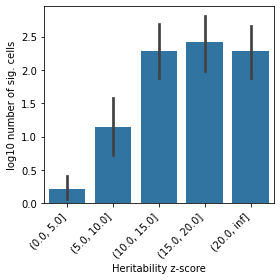

n_sample.log10_nsig.all: n_trait=35, AIT, ALP, ALT, ASM, BMD-HT, BMI, BMR, Breast cancer, CVD, DBP, ECOL, EOS, EY, Eczema, HT, HTN, Hair color, HbA1c, Height, LDL, LYM, MCH, MONO, NCH, PLT, RBC, RDW, RR-ENT, SBP, Smoking, TBIL, TC, TG, WBC, WHR


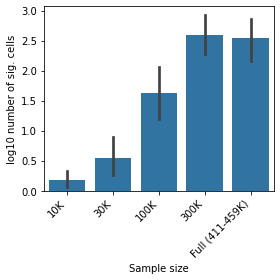

h2g_z_bin.log10_nsig.h2g: n_trait=35
All traits: AIT, ALP, ALT, ASM, BMD-HT, BMI, BMR, Breast cancer, CVD, DBP, ECOL, EOS, EY, Eczema, HT, HTN, Hair color, HbA1c, Height, LDL, LYM, MCH, MONO, NCH, PLT, RBC, RDW, RR-ENT, SBP, Smoking, TBIL, TC, TG, WBC, WHR
h2g Low: n_trait=18, AIT, ALT, ASM, Breast cancer, CVD, ECOL, EY, Eczema, HT, HTN, Hair color, LDL, NCH, RR-ENT, Smoking, TBIL, TC, TG
h2g High: n_trait=17, ALP, BMD-HT, BMI, BMR, DBP, EOS, HbA1c, Height, LYM, MCH, MONO, PLT, RBC, RDW, SBP, WBC, WHR


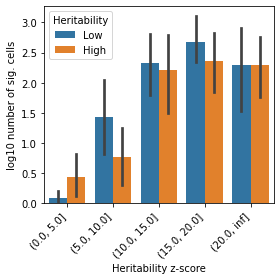

h2g_z_bin.log10_nsig.log10_me: n_trait=14
All traits: AIT, ASM, BMD-HT, BMI, ECOL, EOS, Eczema, Height, NCH, RBC, RDW, SBP, Smoking, WBC
log10_me Low: n_trait=7, AIT, ASM, BMD-HT, EOS, Eczema, RBC, RDW
log10_me High: n_trait=7, BMI, ECOL, Height, NCH, SBP, Smoking, WBC


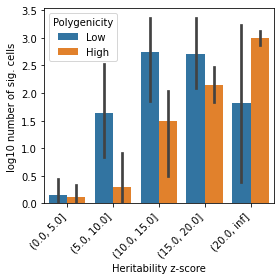

n_sample.log10_nsig.h2g: n_trait=35
All traits: AIT, ALP, ALT, ASM, BMD-HT, BMI, BMR, Breast cancer, CVD, DBP, ECOL, EOS, EY, Eczema, HT, HTN, Hair color, HbA1c, Height, LDL, LYM, MCH, MONO, NCH, PLT, RBC, RDW, RR-ENT, SBP, Smoking, TBIL, TC, TG, WBC, WHR
h2g Low: n_trait=18, AIT, ALT, ASM, Breast cancer, CVD, ECOL, EY, Eczema, HT, HTN, Hair color, LDL, NCH, RR-ENT, Smoking, TBIL, TC, TG
h2g High: n_trait=17, ALP, BMD-HT, BMI, BMR, DBP, EOS, HbA1c, Height, LYM, MCH, MONO, PLT, RBC, RDW, SBP, WBC, WHR


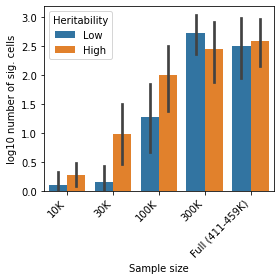

n_sample.log10_nsig.log10_me: n_trait=14
All traits: AIT, ASM, BMD-HT, BMI, ECOL, EOS, Eczema, Height, NCH, RBC, RDW, SBP, Smoking, WBC
log10_me Low: n_trait=7, AIT, ASM, BMD-HT, EOS, Eczema, RBC, RDW
log10_me High: n_trait=7, BMI, ECOL, Height, NCH, SBP, Smoking, WBC


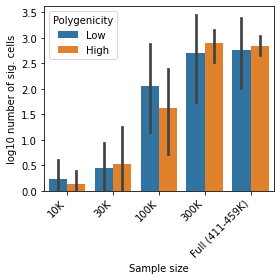

In [6]:
DIC_NAME = {
    'h2g_z_bin' : 'Heritability z-score',
    'n_sample' : 'Sample size',
    'log10_nsig' : 'log10 number of sig. cells',
    'h2g' : 'Heritability',
    'log10_me' : 'Polygenicity',
#     145 : 'UKB2 (134-146K)',
    460 : 'Full (411-459K)'
}

x = 'h2g_z_bin'
y = 'log10_nsig'

# All 
for x in ['h2g_z_bin', 'n_sample']:        
    plt.figure(figsize=[4,4])
    # df_plot
    ind_select = (df_stats['res']!='UKB_145K')
    df_plot = df_stats.loc[ind_select].copy()
    trait_list = list(set(df_plot['trait']))
    print('%s.%s.all: n_trait=%d, %s'
          %(x,y,len(trait_list), ', '.join(sorted([DF_TRAIT_INFO.loc[x, 'Code'] for x in trait_list]))))

    # Plot
    sns.barplot(data=df_plot, x=x, y=y, color='C0')

    if x == 'h2g_z_bin':
        cat_list = list(df_plot[x].cat.categories)
        plt.xticks(np.arange(len(cat_list)), cat_list, rotation=45, ha='right')
    if x == 'n_sample':
        cat_list = sorted(df_plot[x].unique())
        cat_list = [DIC_NAME[x] if x in [145,460] else '%sK'%x for x in cat_list] 
        plt.xticks(np.arange(len(cat_list)), cat_list, rotation=45, ha='right')

    plt.xlabel(DIC_NAME[x])
    plt.ylabel(DIC_NAME[y])

    plt.tight_layout()
    plt.savefig(OUT_PATH+'/UKB_ss.%s.%s.all.svg'%(x,y))
    plt.show()

# Stratified 
for x in ['h2g_z_bin', 'n_sample']:        
    for term in ['h2g', 'log10_me']:
        plt.figure(figsize=[4,4])
        # df_plot
        ind_select = ~df_stats[term].isna()
        ind_select = ind_select & (df_stats['res']!='UKB_145K')
        df_plot = df_stats.loc[ind_select].copy()
        print('%s.%s.%s: n_trait=%d'%(x,y,term,len(set(df_plot['trait']))))
        
        # Stratum
        stratum = DIC_NAME[term]
        df_plot[stratum] = ''
        qbin = pd.qcut(df_plot[term], 2, labels=False)
        df_plot.loc[qbin==0, stratum] = 'Low'
        df_plot.loc[qbin==1, stratum] = 'High'
        
        trait_list = list(set(df_plot['trait']))
        print('All traits: %s'%', '.join(sorted([DF_TRAIT_INFO.loc[x, 'Code'] for x in trait_list])))
        for cat in ['Low', 'High']:
            trait_list = list(set(df_plot.loc[df_plot[stratum]==cat, 'trait']))
            print('%s %s: n_trait=%d, %s'
                  %(term, cat, len(trait_list),
                    ', '.join(sorted([DF_TRAIT_INFO.loc[x, 'Code'] for x in trait_list]))
                   ))
        
        # Plot
        sns.barplot(data=df_plot, x=x, y=y, hue=stratum, hue_order=['Low', 'High'])

        if x == 'h2g_z_bin':
            cat_list = list(df_plot[x].cat.categories)
            plt.xticks(np.arange(len(cat_list)), cat_list, rotation=45, ha='right')
        if x == 'n_sample':
            cat_list = sorted(df_plot[x].unique())
            cat_list = [DIC_NAME[x] if x in [145,460] else '%sK'%x for x in cat_list] 
            plt.xticks(np.arange(len(cat_list)), cat_list, rotation=45, ha='right')
            
        plt.xlabel(DIC_NAME[x])
        plt.ylabel(DIC_NAME[y])

        plt.tight_layout()
        plt.savefig(OUT_PATH+'/UKB_ss.%s.%s.%s.svg'%(x,y,term))
        plt.show()

In [ ]:
import statsmodels.api as sm
ind_select = (df_stats['res']!='UKB_145K')
df_plot = df_stats.loc[ind_select].copy()
for reg_list in [['h2g_z'], ['n_sample'], ['n_sample', 'h2g_z']]:
    res = sm.OLS(df_plot['log10_nsig'], df_plot[reg_list]).fit()
    var_explain_ = 1 - res.mse_resid/res.mse_total
    print(reg_list, var_explain_)

In [71]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             log10_nsig   R-squared (uncentered):                   0.671
Model:                            OLS   Adj. R-squared (uncentered):              0.669
Method:                 Least Squares   F-statistic:                              354.7
Date:                Wed, 26 Jan 2022   Prob (F-statistic):                    7.51e-44
Time:                        00:16:37   Log-Likelihood:                         -276.61
No. Observations:                 175   AIC:                                      555.2
Df Residuals:                     174   BIC:                                      558.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
h2g_z          0.1127      0.006     18.833      0.000       0.101       0.124
==============================================================================
Omnibus:                        0.277   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.871   Jarque-Bera (JB):                0.283
Skew:                          -0.093   Prob(JB):                        0.868
Kurtosis:                       2.936   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
df_plot[['n_sample', 'h2g_z']]

,n_sample,h2g_z
UKB_460K.blood_RBC_DISTRIB_WIDTH,460,17.803279
UKB_460K.blood_MONOCYTE_COUNT,460,16.789116
UKB_460K.disease_RESPIRATORY_ENT,460,14.119048
UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED,460,14.603448
UKB_460K.repro_NumberChildrenEverBorn_Pooled,460,16.782609
...,...,...
UKB_460K.cancer_BREAST.subsample_300K,300,6.125000
UKB_460K.biochemistry_TotalBilirubin.subsample_300K,300,11.478873
UKB_460K.bp_SYSTOLICadjMEDz.subsample_300K,300,25.945055
UKB_460K.disease_HYPERTENSION_DIAGNOSED.subsample_300K,300,22.000000


In [61]:
var_explain_ctrl_ = 1 - res.mse_resid/res.mse_total


In [62]:
var_explain_ctrl_

0.7195379288880466

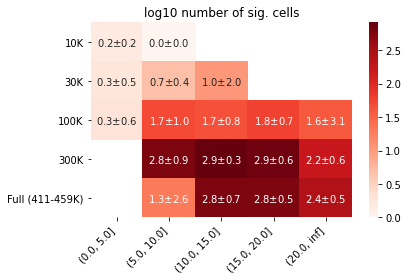

In [33]:
# Heatmap
sample_list = sorted(df_stats['n_sample'].unique())
sample_list.remove(145)
zbin_list = list(df_stats['h2g_z_bin'].cat.categories)
df_plot = pd.DataFrame(index=sample_list, columns=zbin_list, dtype=float)
df_annot = pd.DataFrame(index=sample_list, columns=zbin_list, dtype=str)

for n in sample_list:
    for z in zbin_list:
        ind_select = (df_stats['n_sample']==n) & (df_stats['h2g_z_bin']==z)
        mean_ = df_stats.loc[ind_select, 'log10_nsig'].mean()
        if ind_select.sum()>1:
            se_ = df_stats.loc[ind_select, 'log10_nsig'].std() / np.sqrt(ind_select.sum())
        else:
            se_ = 0
        df_plot.loc[n,z] = mean_
        df_annot.loc[n,z] = r'%0.1f$\pm$%0.1f'%(mean_, se_*1.96)

        
        
plt.figure(figsize=[6,4])
sns.heatmap(df_plot, annot=df_annot, fmt='s', cmap='Reds')
plt.xticks(np.arange(len(zbin_list))+0.5, zbin_list, rotation=45, ha='right')
cat_list = [DIC_NAME[x] if x in [145,460] else '%sK'%x for x in sample_list] 
plt.yticks(np.arange(len(cat_list))+0.5, cat_list, rotation=0, ha='right')
plt.title(DIC_NAME['log10_nsig'])
plt.tight_layout()
# plt.savefig(OUT_PATH+'/UKB_ss.n_sample_vs_z.svg')
plt.show()

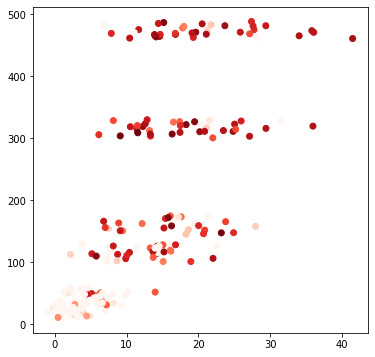

In [49]:
ind_select = ind_select & (df_stats['res']!='UKB_145K')
df_plot = df_stats.loc[ind_select].copy()

plt.figure(figsize=[6,6])
plt.scatter(df_stats['h2g_z'], df_stats['n_sample']+np.random.rand(df_stats.shape[0])*30,
            c=df_stats['log10_nsig'], cmap='Reds', alpha=1)
plt.show()

In [38]:
df_stats['log10_nsig']

UKB_460K.blood_RBC_DISTRIB_WIDTH                          1.857332
UKB_460K.blood_MONOCYTE_COUNT                             3.525174
UKB_460K.disease_RESPIRATORY_ENT                          3.437116
UKB_460K.disease_ALLERGY_ECZEMA_DIAGNOSED                 3.321805
UKB_460K.repro_NumberChildrenEverBorn_Pooled              2.478566
                                                            ...   
UKB_460K.cancer_BREAST.subsample_300K                     2.485721
UKB_460K.biochemistry_TotalBilirubin.subsample_300K       2.296665
UKB_460K.bp_SYSTOLICadjMEDz.subsample_300K                2.733999
UKB_460K.disease_HYPERTENSION_DIAGNOSED.subsample_300K    2.173186
UKB_460K.blood_RED_COUNT.subsample_300K                   0.000000
Name: log10_nsig, Length: 201, dtype: float64